# ABRF LMRG Segmentation

This notebook shows the steps I took to segment the image from the ABRF-LMRG Image Analysis Study.  Details about the study can be found here

https://sites.google.com/view/lmrg-image-analysis-study

conda install -c conda-forge fftw  
pip install sdeconv  
pip install stardist

## Open and show input

Open the input file with a special helper that open imagej tifs and reads and returns the spacings along with the image data.  Then show xyz maximum projections.

1 1 3
(128, 256, 256)
(128, 256, 256)


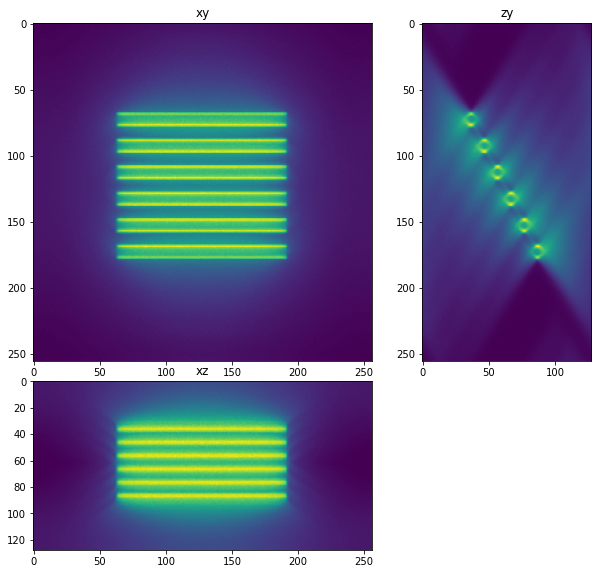

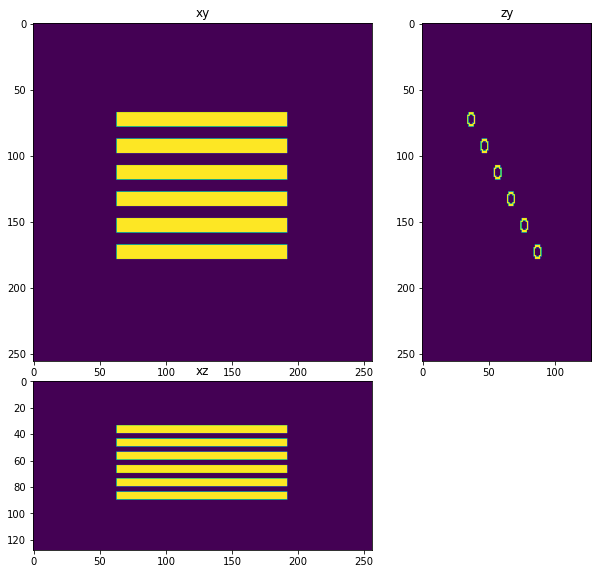

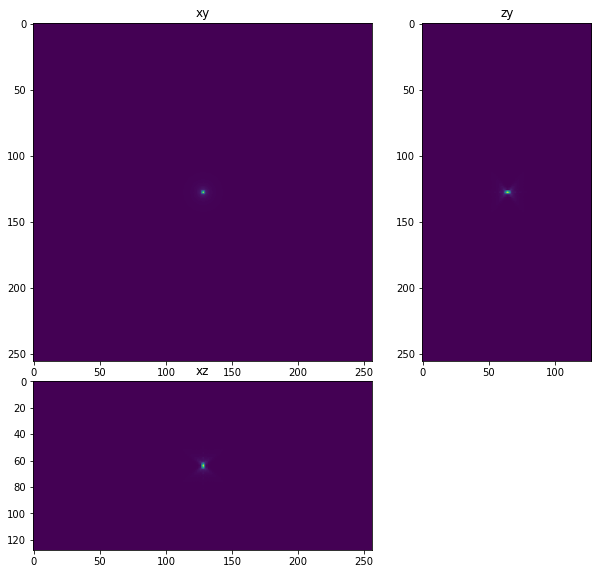

In [1]:
from tnia.io.tifffile_helper import open_ij3D
from tnia.plotting.projections import show_xyz_max
from skimage.io import imread
input_dir = "D:\\images\\"

input_name=input_dir+"\\tnia-python-images\\notebooks\\deconvolution\\bars\\Bars-G10-P30-stack.tif"
true_label_name=input_dir+"\\tnia-python-images\\notebooks\\deconvolution\\bars\\Bars-stack.tif"
psf_name=input_dir+"\\tnia-python-images\\notebooks\\deconvolution\\bars\\PSF-Bars-stack.tif"

#input_name=input_dir+"\\tnia-python-images\\notebooks\\segmentation\\nuclei\\
sx,sy,sz=1,1,3


im_orig = imread(input_name)
true_label = imread(true_label_name)
psf = imread(psf_name)

print(sx, sy, sz)
print(im_orig.shape)
fig=show_xyz_max(im_orig)
fig=show_xyz_max(true_label)
fig=show_xyz_max(psf)

print(true_label.shape)



In [ ]:
from clij2fft.richardson_lucy import richardson_lucy, richardson_lucy_nc
from skimage.filters import threshold_otsu
import matplotlib.pyplot as plt
from skimage.transform import resize
from skimage.filters import threshold_multiotsu
from tnia.morphology.fill_holes import fill_holes_3d_slicer, fill_holes_slicer
from skimage.transform import resize
from skimage.measure import label
from tnia.segmentation.separate import separate_touching2, separate_touching
from stardist.matching import matching
import numpy as np
from skimage.morphology import binary_closing, binary_opening, binary_erosion, ball
from skimage.measure import regionprops

#tests=[200]
tests=[100000]

for i in tests:
    if i==0:
        im_decon=im_orig
    else:
        im_decon=richardson_lucy_nc(im_orig, psf, i, 0)

    
    binary = im_decon>threshold_otsu(im_decon)
    
    labels=label(binary)
    true_labels=label(true_label)

    print((labels!=true_labels).sum())
    
    print(matching(true_labels, labels))
    
    #fig=show_xyz_max(labels)
    #fig=show_xyz_max(true_labels)


get lib


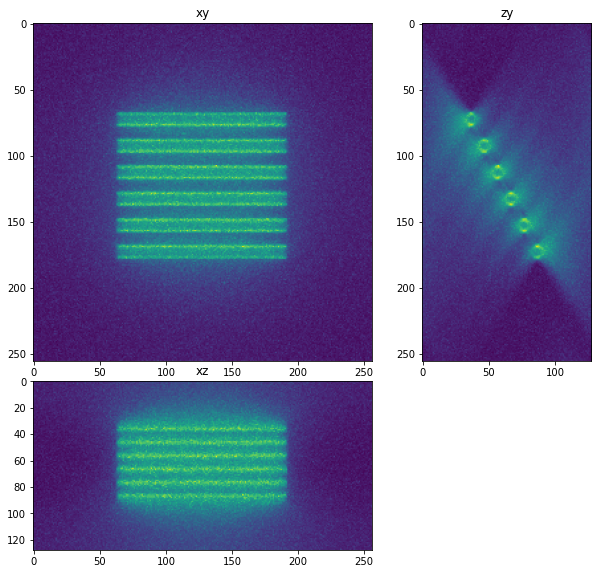

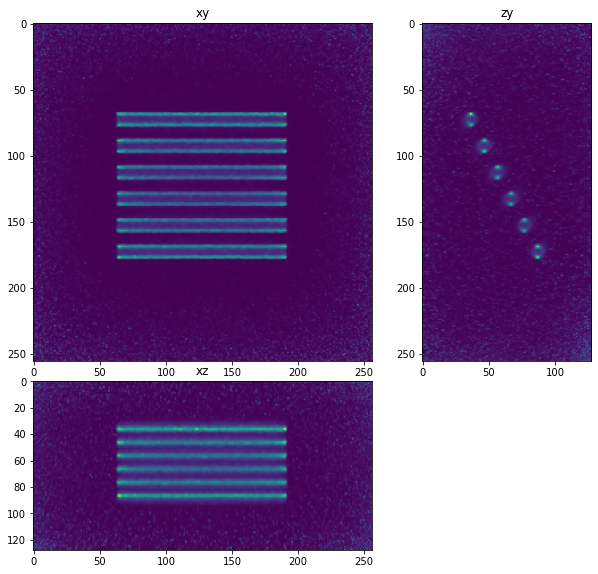

In [12]:
fig=show_xyz_max(im_orig)
fig=show_xyz_max(im_decon)

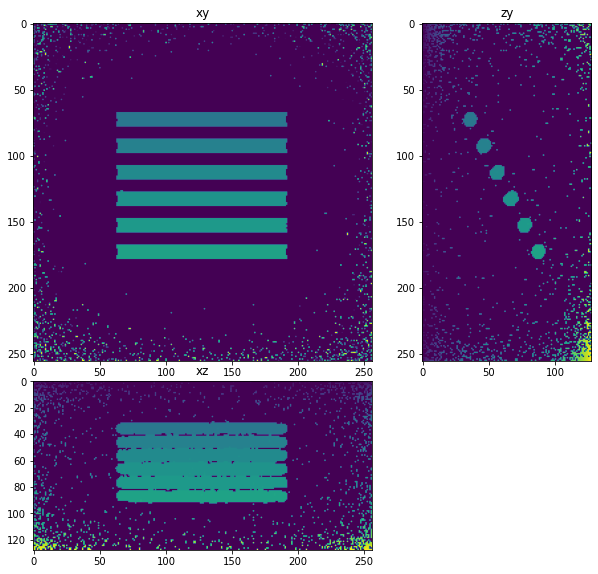

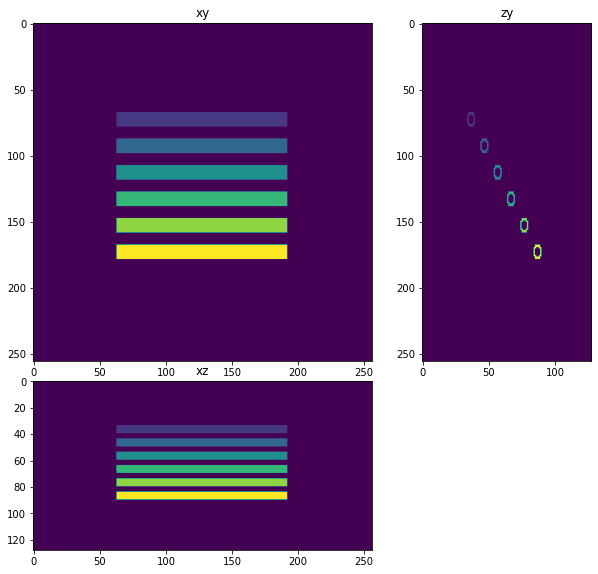

In [13]:
fig=show_xyz_max(labels)
fig=show_xyz_max(true_labels)

In [6]:
from skimage.morphology import closing, opening, ball
metrics =  matching(true_labels, labels)
print(metrics)
labels2=closing(labels, ball(1))
labels2=closing(labels, ball(5))
metrics =  matching(true_labels, labels2)
print(metrics)

Matching(criterion='iou', thresh=0.5, fp=0, tp=5, fn=0, precision=1.0, recall=1.0, accuracy=1.0, f1=1.0, n_true=5, n_pred=5, mean_true_score=0.859158706665039, mean_matched_score=0.859158706665039, panoptic_quality=0.859158706665039)
Matching(criterion='iou', thresh=0.5, fp=0, tp=5, fn=0, precision=1.0, recall=1.0, accuracy=1.0, f1=1.0, n_true=5, n_pred=5, mean_true_score=0.8355808258056641, mean_matched_score=0.8355808258056641, panoptic_quality=0.8355808258056641)


In [67]:
help(cle.closing_labels)

Help on function closing_labels in module pyclesperanto_prototype:

closing_labels(labels_input: Union[numpy.ndarray, pyclesperanto_prototype._tier0._pycl.OCLArray, pyopencl._cl.Image, pyclesperanto_prototype._tier0._pycl._OCLImage], labels_destination: Union[numpy.ndarray, pyclesperanto_prototype._tier0._pycl.OCLArray, pyopencl._cl.Image, pyclesperanto_prototype._tier0._pycl._OCLImage] = None, radius: int = 0) -> Union[numpy.ndarray, pyclesperanto_prototype._tier0._pycl.OCLArray, pyopencl._cl.Image, pyclesperanto_prototype._tier0._pycl._OCLImage]
    Apply a morphological closing operation to a label image.
    
    The operation consists of iterative dilation and erosion of the labels.
    With every iteration, box and diamond/sphere structuring elements are used
    and thus, the operation has an octagon as structuring element.
    
    Parameters
    ----------
    labels_input: Image
    labels_destination: Image, optional
    radius: int, optional
    
    Returns
    -------
   

In [52]:
import pyclesperanto_prototype as cle
labels_cle=cle.opening_labels(labels, radius=1)
labels_cle=cle.closing_labels(labels_cle, radius=5)
labels_cle=cle.pull(labels_cle)
metrics =  matching(true_labels, labels_cle)
print(metrics)

Matching(criterion='iou', thresh=0.5, fp=0, tp=5, fn=0, precision=1.0, recall=1.0, accuracy=1.0, f1=1.0, n_true=5, n_pred=5, mean_true_score=0.8234438896179199, mean_matched_score=0.8234438896179199, panoptic_quality=0.8234438896179199)


In [28]:
import numpy as np
from skimage.morphology import binary_closing, binary_opening, binary_erosion
from skimage.measure import regionprops

object_list=regionprops(labels,im_decon)
labels2=np.zeros_like(labels)

i=1
r=7
for obj in object_list:
    z1,y1,x1,z2,y2,x2=obj.bbox
    temp=np.pad(obj.image,r)
    #temp=binary_erosion(temp, ball(1))
    temp=binary_opening(temp, ball(r))
    temp=binary_closing(temp, ball(r))
    temp=temp[r:-r,r:-r,r:-r]
    labels2[z1:z2,y1:y2,x1:x2][temp==True]=i
    i=i+1

In [29]:
print(matching(true_labels, labels))
print(matching(true_labels, labels2))

Matching(criterion='iou', thresh=0.5, fp=0, tp=5, fn=0, precision=1.0, recall=1.0, accuracy=1.0, f1=1.0, n_true=5, n_pred=5, mean_true_score=0.9278176307678223, mean_matched_score=0.9278176307678223, panoptic_quality=0.9278176307678223)
Matching(criterion='iou', thresh=0.5, fp=0, tp=5, fn=0, precision=1.0, recall=1.0, accuracy=1.0, f1=1.0, n_true=5, n_pred=5, mean_true_score=0.9280058860778808, mean_matched_score=0.9280058860778808, panoptic_quality=0.9280058860778808)


In [ ]:
fig=show_xyz_max(labels2)

In [24]:
import napari
viewer=napari.Viewer()
viewer.add_image(im_orig)
viewer.add_image(im_decon_1000)
viewer.add_image(im_decon)
#viewer.add_labels(true_labels)
#viewer.add_labels(labels)

__init__.py (168): Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "C:\Users\bnort\miniconda3\envs\i2k_tests\lib\site-packages\zmq\eventloop\zmqstream.py", line 431, in _run_callback
    callback(*args, **kwargs)
  File "C:\Users\bnort\miniconda3\envs\i2k_tests\lib\site-packages\jupyter_client\threaded.py", line 122, in _handle_recv
    msg_list = self.ioloop._asyncio_event_loop.run_until_complete(get_msg(future_msg))
  File "C:\Users\bnort\miniconda3\envs\i2k_tests\lib\asyncio\base_events.py", line 623, in run_until_complete
    self._check_running()
  File "C:\Users\bnort\miniconda3\envs\i2k_tests\lib\asyncio\base_events.py", line 585, in _check_running
    raise Ru

<Image layer 'im_decon' at 0x1fc34250970>

# Thresholding

Thresholding was done using a global Otsu threshold.  

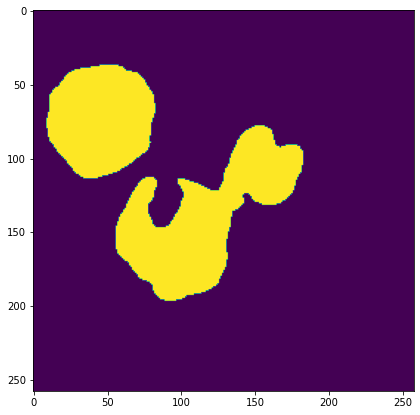

In [4]:
from skimage.filters import threshold_otsu
import matplotlib.pyplot as plt
from skimage.transform import resize
from skimage.filters import threshold_multiotsu

# we resize here because downstream we will do watershed, and watershed tends to work better with isotropic voxels
resized= resize(im_decon, [int(sz*im_orig.shape[0]/sx),im_orig.shape[1], im_orig.shape[2]])
#binary = resized>threshold_otsu(resized)
#binary = resized>threshold_otsu(resized[binary==0])
binary = resized>threshold_multiotsu(resized)[0]

fig, ax = plt.subplots(figsize=(7, 7))
ax.imshow(binary[65,:,:])


## Binary Morphology

The thresholded result had many holes and 'tunnels' in it which could lead to over-splitting at the Watershed step.  Thus we use morphological operations to fill the holes.  In this case I wrote I customized hole filling routine which applies 2D hole filling, slice by slice, in each 3D direction.  This approach fills 'tunnels' which otherwise could not be filled

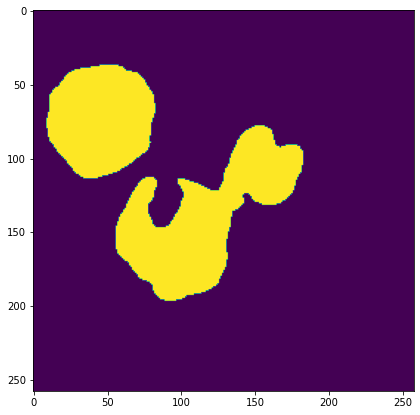

In [5]:
from tnia.morphology.fill_holes import fill_holes_3d_slicer, fill_holes_slicer

fill_holes_slicer(binary,1000)


fig, ax = plt.subplots(figsize=(7, 7))
ax.imshow(binary[65,:,:])

## Watershed

After thresholding some of the nuclei are toucing.  In this step we use 3D Watershed to split touching objects.  Separating object routines tend to be a 'recipe' with peak finding, distance map, and watershed steps.  The code used in this case can be found [here](https://github.com/True-North-Intelligent-Algorithms/tnia-python/blob/main/tnia/segmentation/separate.py#L44)   

(5, 3)


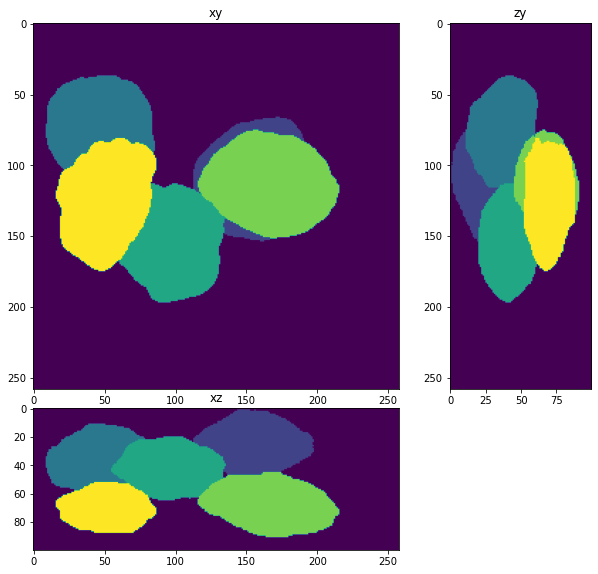

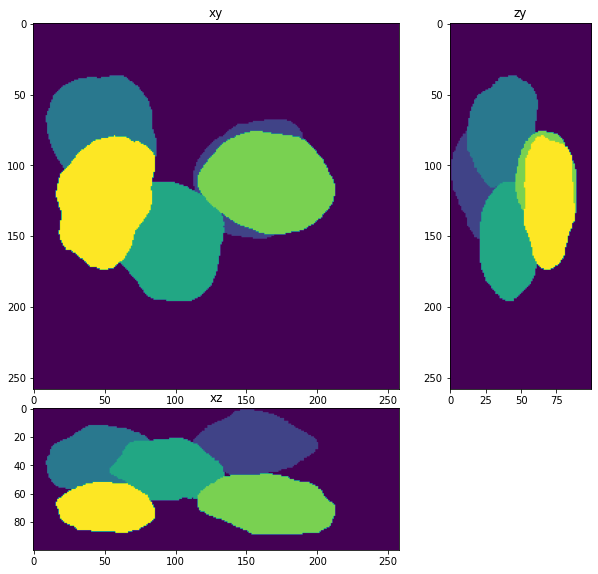

In [26]:
from skimage.transform import resize
from skimage.measure import label
from tnia.segmentation.separate import separate_touching2, separate_touching

labels, _, = separate_touching2(binary, binary, 5, [15,15,15],[5,5,5])
labels = resize(labels, [im_orig.shape[0],im_orig.shape[1], im_orig.shape[2]], preserve_range=True, order=0, anti_aliasing=False).astype('int32')
true_labels = resize(true_label, [im_orig.shape[0],im_orig.shape[1], im_orig.shape[2]], preserve_range=True, order=0, anti_aliasing=False).astype('int32')

labels=label(labels)
true_labels=label(true_labels)

fig=show_xyz_max(labels)    
fig=show_xyz_max(true_labels)    



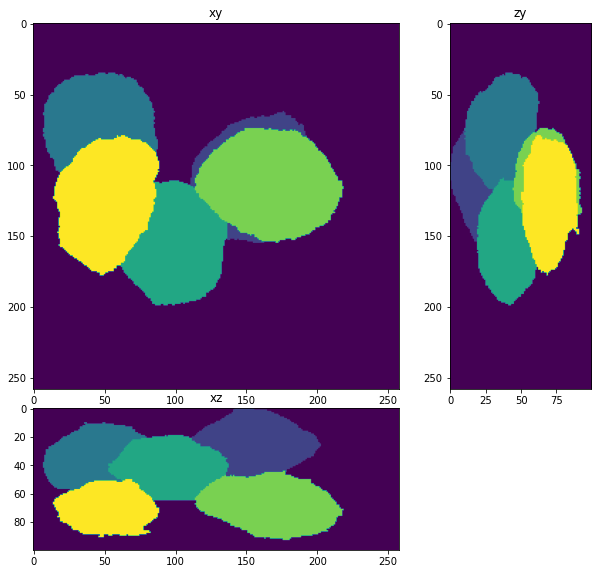

In [7]:
from tnia.morphology.fill_holes import fill_holes_3d_slicer_labels
# fill holes in label
labels_=labels.copy()
fill_holes_3d_slicer_labels(labels_, 1000,2)
fig=show_xyz_max(labels_)

In [10]:
from stardist.matching import matching

metrics_true =  matching(true_labels, true_labels)
metrics =  matching(true_labels, labels_)

print(metrics_true)
print(metrics)

Matching(criterion='iou', thresh=0.5, fp=0, tp=5, fn=0, precision=1.0, recall=1.0, accuracy=1.0, f1=1.0, n_true=5, n_pred=5, mean_true_score=1.0, mean_matched_score=1.0, panoptic_quality=1.0)
Matching(criterion='iou', thresh=0.5, fp=0, tp=5, fn=0, precision=1.0, recall=1.0, accuracy=1.0, f1=1.0, n_true=5, n_pred=5, mean_true_score=0.8782073974609375, mean_matched_score=0.8782073974609375, panoptic_quality=0.8782073974609375)


In [130]:
print((labels!=true_labels).sum())

1364621


# 3D Visualization
It's easy to bring up the Napari 3D Viewer right from a notebook and take a look at inputs, results and intermediate steps

In [23]:
from skimage.io import imsave
imsave('decon_tv_0005_300.tif',im_decon)

In [12]:
# start napari
import napari
viewer = napari.Viewer()

# show images
viewer.add_image(im_orig, scale = [sz,sy,sz])
viewer.add_image(im_decon, scale = [sz,sy,sz])
viewer.add_labels(labels.astype('int32'), scale = [sz,sy,sz])
viewer.add_labels(true_labels.astype('int32'), scale = [sz,sy,sz])



__init__.py (168): Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "C:\Users\bnort\miniconda3\envs\i2k_tests\lib\site-packages\zmq\eventloop\zmqstream.py", line 431, in _run_callback
    callback(*args, **kwargs)
  File "C:\Users\bnort\miniconda3\envs\i2k_tests\lib\site-packages\jupyter_client\threaded.py", line 122, in _handle_recv
    msg_list = self.ioloop._asyncio_event_loop.run_until_complete(get_msg(future_msg))
  File "C:\Users\bnort\miniconda3\envs\i2k_tests\lib\asyncio\base_events.py", line 623, in run_until_complete
    self._check_running()
  File "C:\Users\bnort\miniconda3\envs\i2k_tests\lib\asyncio\base_events.py", line 585, in _check_running
    raise Ru

<Labels layer 'Labels [1]' at 0x28939940d90>

## Data Table

At this step we create a data table.  We use a helper to compute the region properties of the objects in our labelling and return centroid, intensity and volume of the objects in a Pandas table.

In [66]:
from tnia.segmentation.pandas_helper import get_df_centroid_intensity_volume_3D
stats=get_df_centroid_intensity_volume_3D(labels, im_decon, sx, sy, sz)

stats.head()

,x,y,z,intensity,volume
0,19.071710,13.298704,4.986038,2.159182e+07,562.519677
1,11.913009,18.666474,8.467654,2.240987e+07,554.500105
2,5.735224,9.247759,7.396085,2.228634e+07,547.801800
3,6.295513,15.305999,13.908992,1.520714e+07,425.889581
4,20.571488,13.961784,13.548049,2.186847e+07,555.042713


## Plotting

At this point we have our data in a table and we can also use Pandas (and matplotlib) to create figure. It is not a very big table.  We'd need much more data to get significant statistics.  

<AxesSubplot:ylabel='Frequency'>

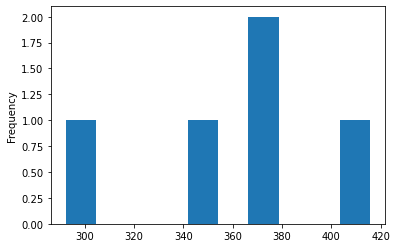

In [55]:
stats.volume.plot.hist()

In [11]:
help(metrics)

Help on Matching in module stardist.matching object:

class Matching(builtins.tuple)
 |  Matching(criterion, thresh, fp, tp, fn, precision, recall, accuracy, f1, n_true, n_pred, mean_true_score, mean_matched_score, panoptic_quality)
 |  
 |  Matching(criterion, thresh, fp, tp, fn, precision, recall, accuracy, f1, n_true, n_pred, mean_true_score, mean_matched_score, panoptic_quality)
 |  
 |  Method resolution order:
 |      Matching
 |      builtins.tuple
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __getnewargs__(self)
 |      Return self as a plain tuple.  Used by copy and pickle.
 |  
 |  __repr__(self)
 |      Return a nicely formatted representation string
 |  
 |  _asdict(self)
 |      Return a new dict which maps field names to their values.
 |  
 |  _replace(self, /, **kwds)
 |      Return a new Matching object replacing specified fields with new values
 |  
 |  ----------------------------------------------------------------------
 |  Class methods defined h